# Import Libraries

In [29]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
from pmdarima import auto_arima, ARIMA, model_selection

# EDA

In [2]:
transaction = pd.read_csv('transactions.csv')
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [3]:
transaction['transactions'].max()

np.int64(8359)

In [4]:
transaction['date'] = pd.to_datetime(transaction['date'], format= '%Y-%m-%d')
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


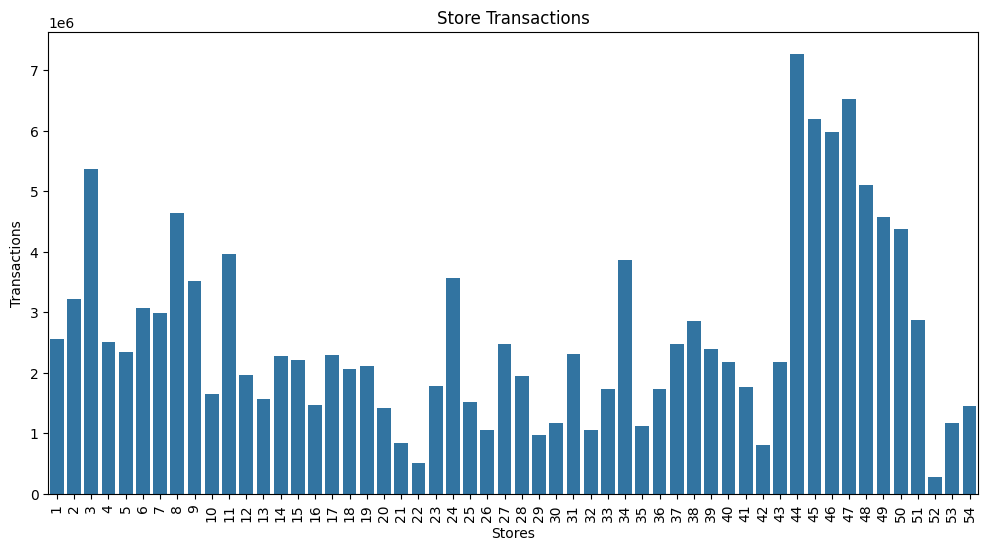

In [5]:
# total trnsactions per store

store_transactions = transaction.groupby('store_nbr')['transactions'].sum().reset_index()

store_transactions.head()
plt.figure(figsize=(12,6))
sns.barplot(x='store_nbr', y='transactions', data= store_transactions)

plt.title('Store Transactions')
plt.xlabel('Stores')
plt.ylabel('Transactions')
plt.xticks(rotation=90)

plt.show()

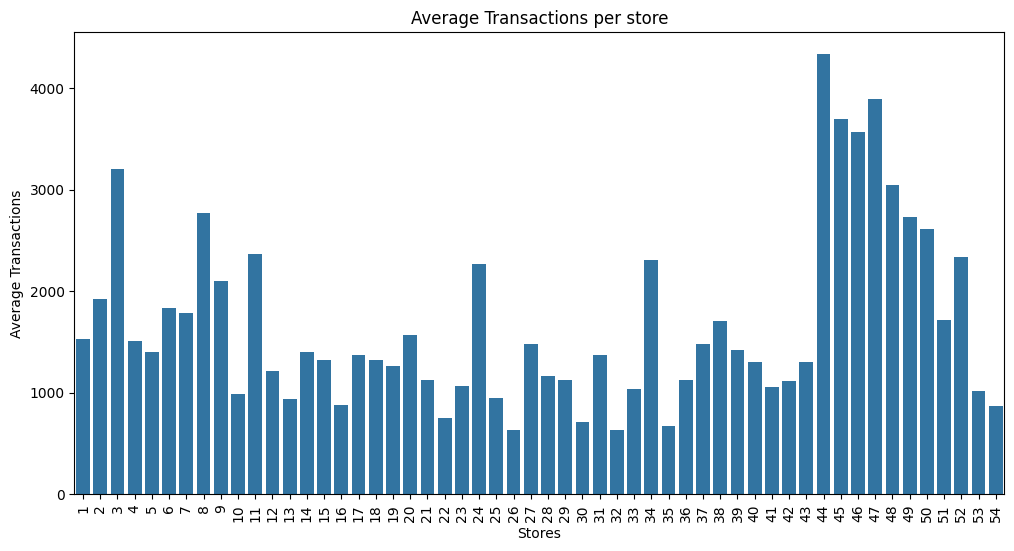

In [6]:
# average transactions per store

avg_transactions = transaction.groupby('store_nbr')['transactions'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='store_nbr', y='transactions', data= avg_transactions)

plt.title('Average Transactions per store')
plt.xlabel('Stores')
plt.ylabel('Average Transactions')
plt.xticks(rotation=90)
plt.show()


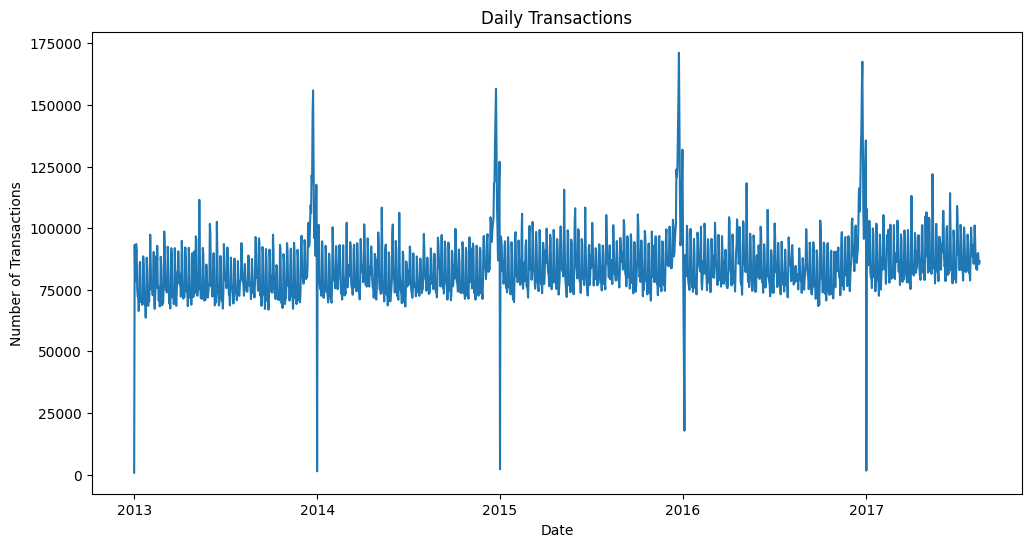

In [7]:
daily_trnsc = transaction.groupby('date', as_index=False)['transactions'].sum()
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y = 'transactions', data= daily_trnsc)
plt.title('Daily Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')

plt.show()

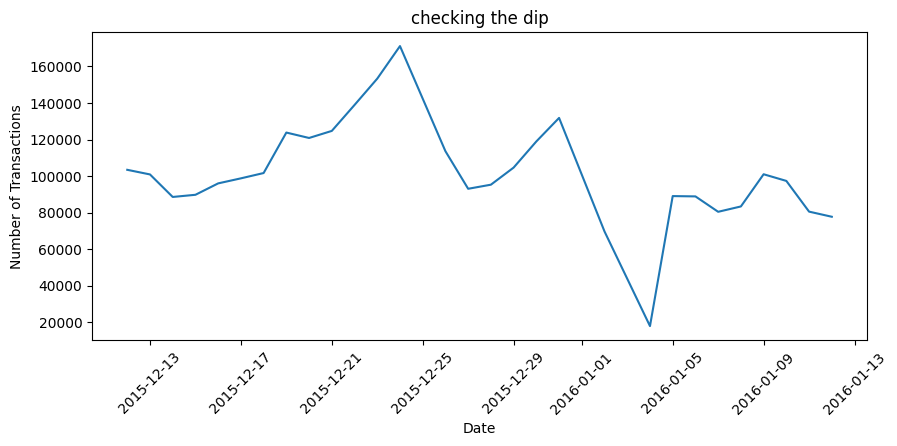

In [8]:
# checking why there is a dip at the beginning of every year 
plt.figure(figsize=(10,4))
filtered_daily_trnsc = daily_trnsc[(daily_trnsc['date'] >= '2015-12-12') & (daily_trnsc['date'] <= '2016-01-12')]
sns.lineplot(x='date', y='transactions', data=filtered_daily_trnsc)

plt.title('checking the dip')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

only logical explaination is probably the stores are closed for new years holiday

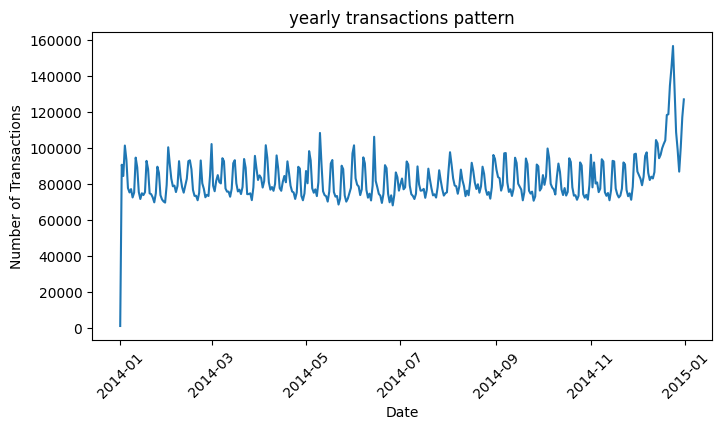

In [9]:
# yearly transactions pattern
plt.figure(figsize=(8,4))
filtered_daily_trnsc = daily_trnsc[(daily_trnsc['date'] >= '2014-01-01') & (daily_trnsc['date'] <= '2014-12-31')]
sns.lineplot(x='date', y='transactions', data=filtered_daily_trnsc)

plt.title('yearly transactions pattern')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

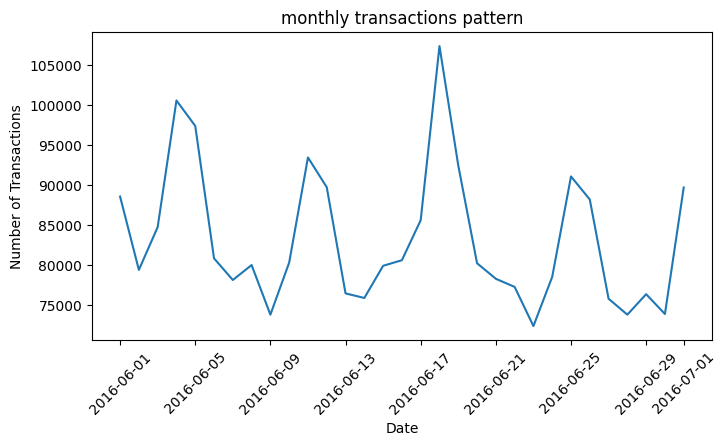

In [10]:
# monthly transaction pattern

plt.figure(figsize=(8,4))
filtered_daily_trnsc = daily_trnsc[(daily_trnsc['date'] >= '2016-06-01') & (daily_trnsc['date'] <= '2016-07-01')]
sns.lineplot(x='date', y='transactions', data=filtered_daily_trnsc)

plt.title('monthly transactions pattern')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

In [11]:
dd = daily_trnsc[daily_trnsc['transactions']==0]
dd

,date,transactions


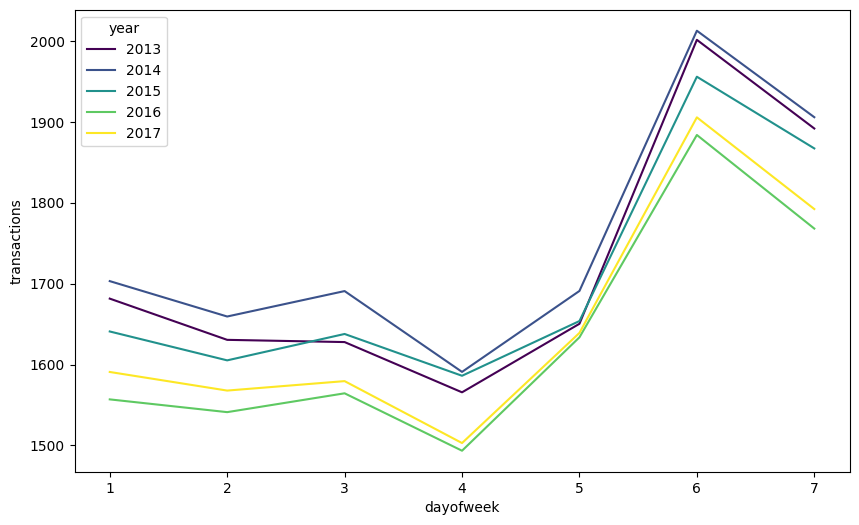

In [12]:
# which day of the week people spend more

a = transaction.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=a, x='dayofweek', y='transactions', hue='year', palette='viridis')
plt.show()

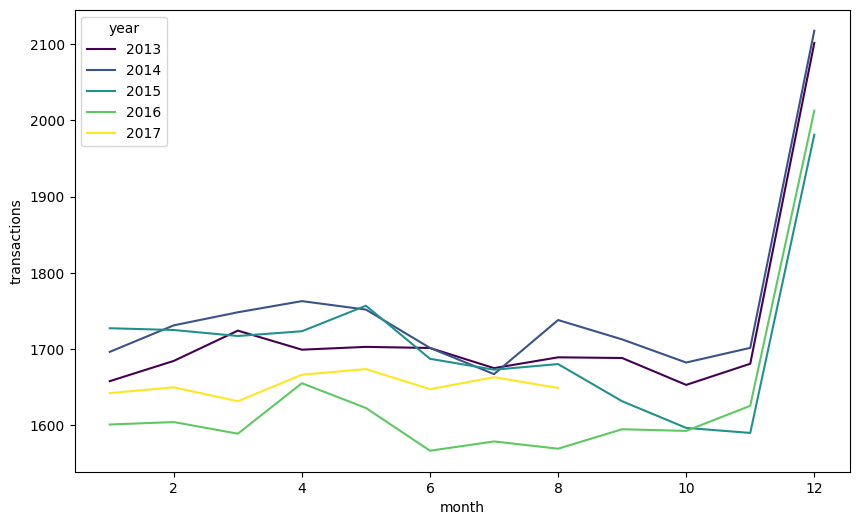

In [13]:
# which month do people spend more

a = transaction.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
a = a.groupby(["year", "month"]).transactions.mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=a, x='month', y='transactions', hue='year', palette='viridis')
plt.show()

In [14]:
daily_trnsc.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573


In [15]:
daily_trnsc.set_index('date', inplace=True)

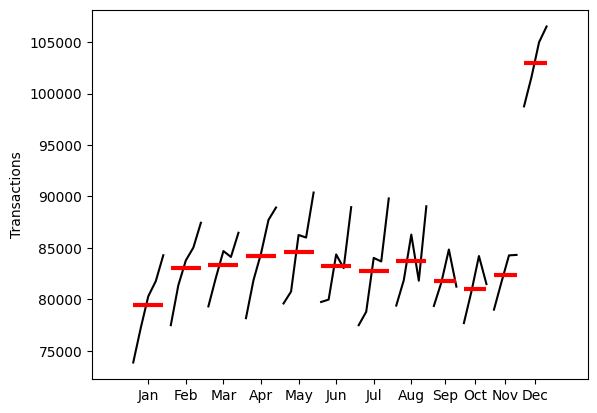

In [16]:
# plot the monthly seasonality

month_plot(daily_trnsc['transactions'].resample('ME').mean(), ylabel='Transactions')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_44944\1988994256.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(daily_trnsc['transactions'].resample('Q').mean(), ylabel='Transactions')


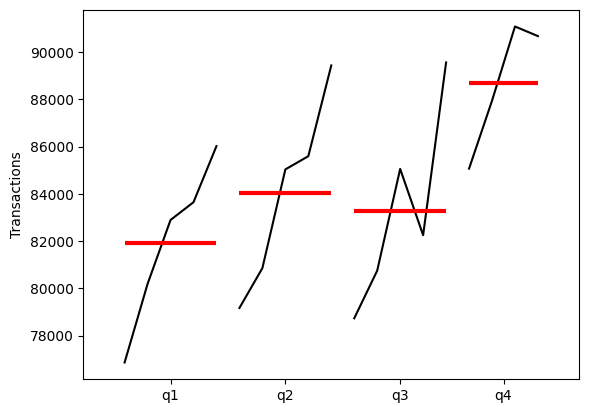

In [17]:
# plot quarterly seasonality

quarter_plot(daily_trnsc['transactions'].resample('Q').mean(), ylabel='Transactions')
plt.show()

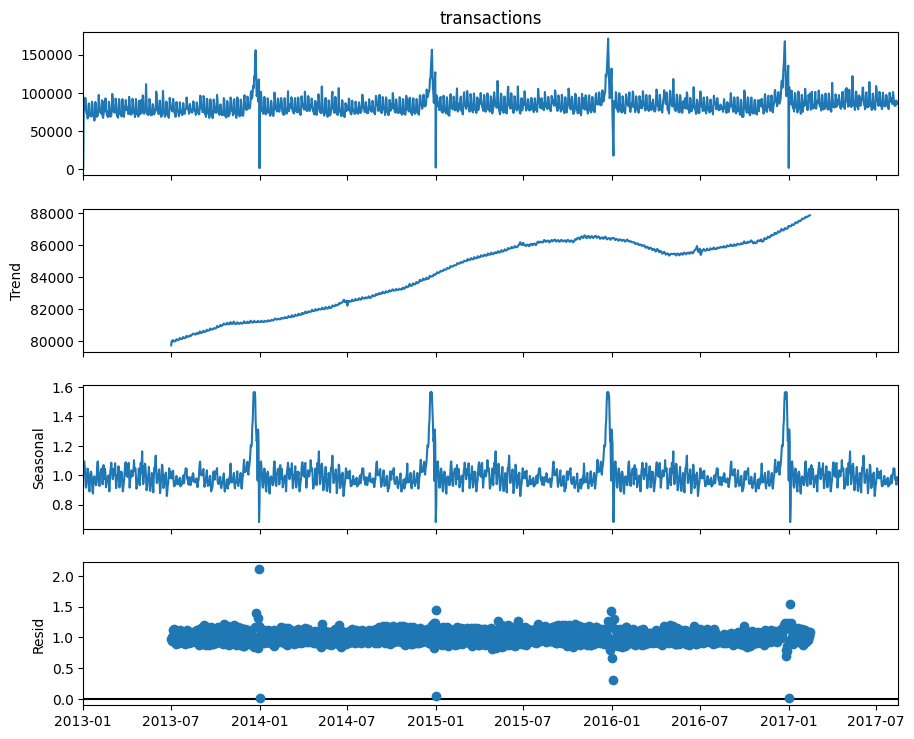

In [18]:
# seasonal decompositon

decomposition = seasonal_decompose(daily_trnsc['transactions'], model='mul', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

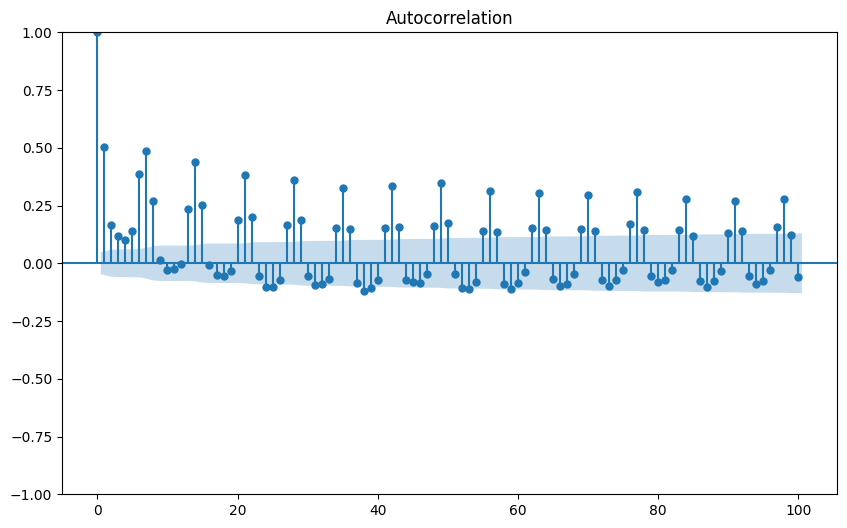

In [19]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(daily_trnsc['transactions'], lags = 100, ax=ax) # 100 lags means 100 days back. 
plt.show()

# seasonal lag is 1 point back each. 
# the gaps in between suggest weekly seasonality.

Auto Correlation tells us if there is info in the past. The points inside the blue shaded area are statistically insignificant. Compares todays amount to the past. 

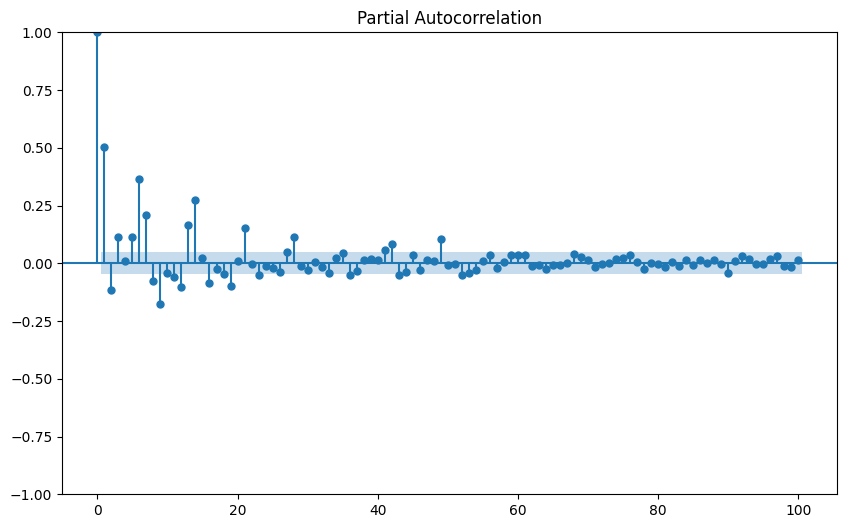

In [20]:
# plot the partial auto correaltion

fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(daily_trnsc['transactions'], lags = 100, ax=ax)
plt.show()

Partial auto correalation tells us there is direct connection between datapoints at various times with out the effect of points in between. (Without one point influencing the other). PACF is more specific.

In [28]:
# Stationarity test

result = adfuller(daily_trnsc.transactions)
# print(result)
print('p-value: %f' % result[1])

# interpreting the result

if result[1] < 0.05:
    print('the evidence suggest that the time series is stationary')
else:
    print('the evidence suggest that the time series is non stationary')

p-value: 0.000000
the evidence suggest that the time series is stationary


* A time series can be stationary with a seasonal pattern if that pattern’s amplitude (strength) and timing remain consistent.
* Stationarity ensures the series is stable.
* Seasonality reflects repeating patterns — this doesn’t violate stationarity if those patterns remain consistent.

# Train Test Split

In [31]:
daily_trnsc.head()

,transactions
date,
2013-01-01,770
2013-01-02,93215
2013-01-03,78504
2013-01-04,78494
2013-01-05,93573


In [32]:
daily_trnsc.tail()

,transactions
date,
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993
2017-08-14,85448
2017-08-15,86561


It is not necessary or efficient for the model to be trained on data longer than 4 years.

In [33]:
new_df = daily_trnsc.loc['2015-01-01':'2017-08-15']
new_df.head()

,transactions
date,
2015-01-01,2202
2015-01-02,96809
2015-01-03,96288
2015-01-04,94496
2015-01-05,88880


In [34]:
new_df.tail()

,transactions
date,
2017-08-11,89551
2017-08-12,89927
2017-08-13,85993
2017-08-14,85448
2017-08-15,86561


In [35]:
# splitting the data into train and test

test_days = 30
train, test = new_df.iloc[:-test_days], new_df.iloc[-test_days:]
test 

,transactions
date,
2017-07-17,85477
2017-07-18,82267
2017-07-19,83265
2017-07-20,82423
2017-07-21,88613
2017-07-22,97358
2017-07-23,94170
2017-07-24,85120
2017-07-25,81930


## SARIMA

In [ ]:
model_sarima = auto_arima(train['transactions'], m=7)
model_sarima.summary()

c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ahmed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\d

# Holidays

In [22]:
holiday = pd.read_csv('holidays_events.csv')
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
holiday.shape

(350, 6)

In [24]:
holiday['date'] = pd.to_datetime(holiday['date'], format= '%Y-%m-%d')
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [25]:
holiday.rename(columns={'type':'day_type'}, inplace=True)

In [26]:
holiday['day_type'].value_counts()

day_type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

### Transaction at different type of holidays


In [27]:
holi_tr = transaction.merge(holiday, on='date', how='left')
holi_tr.head()

,date,store_nbr,transactions,day_type,locale,locale_name,description,transferred
0,2013-01-01,25,770,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,1,2111,NaN,NaN,NaN,NaN,NaN
2,2013-01-02,2,2358,NaN,NaN,NaN,NaN,NaN
3,2013-01-02,3,3487,NaN,NaN,NaN,NaN,NaN
4,2013-01-02,4,1922,NaN,NaN,NaN,NaN,NaN


In [28]:
holi_tr['day_type'] = holi_tr['day_type'].fillna('Not Holiday')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_10752\4195457848.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='transactions', y='day_type', data=holi_tr, palette='viridis')


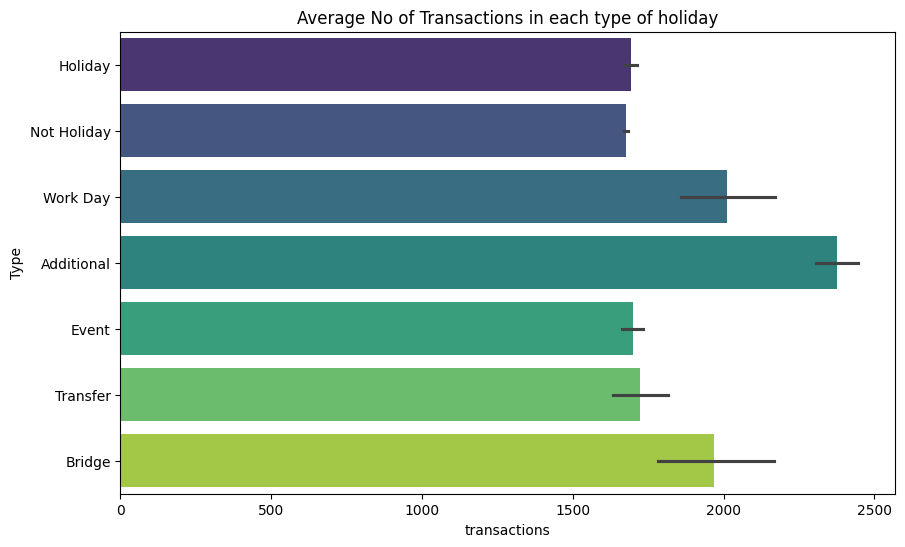

In [29]:
avg_sales_by_holiday = holi_tr.groupby('day_type')['transactions'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='transactions', y='day_type', data=holi_tr, palette='viridis')
plt.title('Average No of Transactions in each type of holiday')
plt.xlabel('transactions')
plt.ylabel('Type')
plt.show()